### Date: 20 March 2017

Aim: The aim of this notebook is to learn parameters from Austin region and use them to predict for San Diego region.

In [1]:
import sys

In [2]:
sys.path.append("../code/")

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
import sys, traceback
from docopt import docopt
import pandas as pd
import time
import numpy as np
import os
np.random.seed(0)

from common_functions import create_region_df, features_dict, create_feature_combinations, create_df_main
from matrix_factorisation import nmf_features, prepare_df_factorisation,prepare_known_features, create_matrix_factorised, create_prediction

## Learning the appliance factors for fridge from Austin regin

In [5]:
year=2014
seed = 0
test_home=54
train_regions = ["Austin","Boulder","SanDiego"]
train_fraction_dict = {region:0 for region in train_regions}
train_fraction_dict['Austin']=1.0
test_region = 'Austin'
feature_list = ['energy','home']
appliance="fridge"
feature_comb = ['None']
lat = 2

In [6]:
df, dfc, X_matrix, X_normalised, col_max, col_min, \
    appliance_cols, aggregate_cols, static_features, max_f = prepare_df_factorisation(appliance, year, train_regions,
                                                                                      train_fraction_dict,
                                                                                     test_region, test_home,
                                                                                     feature_list, seed, 3000, 0)

In [7]:
def f(year, seed, test_home, train_regions, train_fraction_dict,test_region
              , feature_list, appliance, feature_comb, lat, idx_item=None, data_item=None):
    df, dfc, X_matrix, X_normalised, col_max, col_min, \
    appliance_cols, aggregate_cols, static_features, max_f = prepare_df_factorisation(appliance, year, train_regions,
                                                                                      train_fraction_dict,
                                                                                     test_region, test_home,
                                                                                     feature_list, seed, 3000, 0)

    idx_user, data_user = prepare_known_features(feature_comb, static_features, X_normalised)

    A = create_matrix_factorised(appliance, test_home, X_normalised)
    X, Y, res = nmf_features(A=A, k=lat, constant=0.01, regularisation=False,
                        idx_user=idx_user, data_user=data_user,
                         idx_item=idx_item, data_item=data_item, MAX_ITERS=10)
    return X, Y, res, df
    


In [8]:
X_austin ={}
Y_austin= {}
for appliance in ['fridge','hvac']:
    X_austin[appliance], Y_austin[appliance], res_sd, df_austin = f(year, seed, 22, train_regions, {"Austin":1.0,"Boulder":0,"SanDiego":0}, 
              "Austin", feature_list, appliance, feature_comb, lat)

In [9]:
from common_functions import valid_homes_data

In [10]:
year=2014
seed = 0
train_regions = ["Austin","Boulder","SanDiego"]
train_fraction_dict = {region:0 for region in train_regions}
train_fraction_dict['SanDiego']=1.0
test_region = 'SanDiego'
feature_list = ['energy','home']
feature_comb = ['None']
lat = 2

In [11]:
import sys

In [12]:
out = {}
for appliance in ['fridge','hvac']:
    print appliance
    out[appliance] = {}
    for reuse_factors in [True, False]:

        out[appliance][reuse_factors]={}
        total = 1.0*len(valid_homes_data)
        for i, test_home in enumerate(valid_homes_data['SanDiego'][appliance][:]):
            print test_home
            df, dfc, X_matrix, X_normalised, col_max, col_min, appliance_cols, aggregate_cols, static_features, max_f = prepare_df_factorisation(appliance, year, train_regions,
                                                                                              train_fraction_dict,
                                                                                             test_region, test_home,
                                                                                             feature_list, seed, 3000, 0)

            idx_user, data_user = prepare_known_features(feature_comb, static_features, X_normalised)
            A = create_matrix_factorised(appliance, test_home, X_normalised)

            if reuse_factors:
                from collections import OrderedDict
                data_items = OrderedDict()
                idx_items = OrderedDict()

                for count in range(X_austin[appliance].shape[0]):
                    data_items['lat_%d' %count] = np.array(X_austin[appliance][count]).flatten()
                    idx_items['lat_%d' %count] = np.array(range(X_austin[appliance][count].size))
            else:

                data_items = None
                idx_items = None
            X, Y, res = nmf_features(A=A, k=lat, constant=0.01, regularisation=False,
                                idx_user=idx_user, data_user=data_user,
                                 idx_item=idx_items, data_item=data_items, MAX_ITERS=10)
            pred_df = create_prediction(test_home, X, Y, X_normalised, appliance,
                                   col_max, col_min, appliance_cols)
            out[appliance][reuse_factors][test_home]=pred_df

fridge
54
203
1450
1524
1731
3687
3864
3938
4095
4329
4495
4934
5938
6377
6429
6497
6547
7062
7114
7409
7639
8061
8342
8574
8733
9213
9370
9585
9612
9775
9836
54
203
1450
1524
1731
3687
3864
3938
4095
4329
4495
4934
5938
6377
6429
6497
6547
7062
7114
7409
7639
8061
8342
8574
8733
9213
9370
9585
9612
9775
9836
hvac
54
203
527
1450
1524
1731
2031
2354
2606
3687
3864
3938
4083
4095
4495
4761
4934
5938
6377
6429
6497
6547
7062
7114
7409
7639
8061
8342
8574
8733
9213
9370
9585
9612
9775
9836
54
203
527
1450
1524
1731
2031
2354
2606
3687
3864
3938
4083
4095
4495
4761
4934
5938
6377
6429
6497
6547
7062
7114
7409
7639
8061
8342
8574
8733
9213
9370
9585
9612
9775
9836


In [49]:
pd.DataFrame(out['hvac'][False]).mean(axis=1)

hvac_5      88.919244
hvac_6      64.771631
hvac_7     164.734160
hvac_8     182.733879
hvac_9     213.462511
hvac_10     82.308020
dtype: float64

In [50]:
pd.DataFrame(out['hvac'][True]).mean(axis=1)

hvac_5      50.774597
hvac_6     107.139685
hvac_7     125.101681
hvac_8     156.090496
hvac_9     111.995198
hvac_10     68.843856
dtype: float64

In [18]:
from common_functions import compute_rmse_fraction

In [19]:
res = {}
for appliance in ['hvac','fridge']:
    res[appliance] = {}
    for reuse_factors in [True, False]:
        if reuse_factors:
            string = "Transferred from Austin"
        else:
            string = "Learnt from SD"
        res[appliance][string] =compute_rmse_fraction(appliance,pd.DataFrame(out[appliance][reuse_factors]).T,
                                                             "SanDiego")[2]



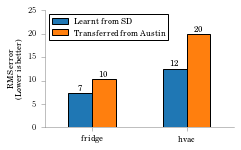

In [23]:
from plot_functions import autolabel, latexify, tableau20blind, format_axes
latexify()
ax = pd.DataFrame(res).T.plot(kind="bar",rot=0, colors=tableau20blind[::2])
plt.ylabel("RMS error \n(Lower is better)")
rects = ax.patches
autolabel(rects, ax)
format_axes(ax)
plt.savefig("/Users/nipunbatra/git/scalable-nilm/results/transfer.png",bbox_inches="tight")
plt.savefig("/Users/nipunbatra/git/scalable-nilm/results/transfer.pdf",bbox_inches="tight")

In [29]:
difference_fraction = {}
for appliance in ['hvac','fridge']:
    difference_fraction[appliance] = {}
    for reuse_factors in [True, False]:
        if reuse_factors:
            string = "Transferred from Austin"
        else:
            string = "Learnt from SD"
        gtf, prf, rms = compute_rmse_fraction(appliance,pd.DataFrame(out[appliance][reuse_factors]).T,
                                                             "SanDiego")
        errors[appliance][string] = (prf-gtf).mean().mean()


In [39]:
appliance="hvac"
gtf, prf, rms = compute_rmse_fraction(appliance,pd.DataFrame(out[appliance][False]).T,
                                                             "SanDiego")

In [40]:
gtf_au, prf_au, rms = compute_rmse_fraction(appliance,pd.DataFrame(out[appliance][True]).T,
                                                             "SanDiego")

In [43]:
prf.describe()

,hvac_5,hvac_6,hvac_7,hvac_8,hvac_9,hvac_10
count,32.000000,33.000000,36.000000,36.000000,33.000000,30.000000
mean,20.435769,13.950783,31.686473,32.135224,36.231193,21.352196
std,9.082356,9.778481,11.545395,9.591072,8.839744,7.257142
min,6.762588,-0.924343,13.944217,14.392527,18.839719,5.284921
25%,13.700517,5.077595,23.186018,24.327553,29.850137,17.716894
50%,19.132000,15.579229,31.430446,32.097923,37.555795,21.105869
75%,24.668757,20.136384,37.294609,37.733352,42.400953,24.399107
max,42.412478,35.534735,72.188101,59.436813,60.682946,39.959139


In [44]:
prf_au.describe()

,hvac_5,hvac_6,hvac_7,hvac_8,hvac_9,hvac_10
count,32.000000,33.000000,36.000000,36.000000,33.000000,30.000000
mean,13.090966,29.655388,24.000917,28.569353,20.337267,18.705190
std,7.651326,14.693231,11.309821,14.596611,12.466929,14.607577
min,6.462837,16.325651,12.696327,16.366930,10.102777,9.006837
25%,9.157160,19.203693,17.350162,19.883750,13.398831,11.939282
50%,10.187399,23.607309,19.642749,22.601932,15.779995,13.563312
75%,14.025699,32.328218,25.247389,27.611098,17.435926,17.647480
max,40.630312,65.530177,60.012450,70.151293,55.562191,78.764302


In [51]:
X_sd ={}
Y_sd= {}
for appliance in ['fridge','hvac']:
    X_sd[appliance], Y_sd[appliance], res_sd, df_austin = f(year, seed, 54, train_regions, {"Austin":0.0,"Boulder":0,"SanDiego":1.0}, 
              "SanDiego", feature_list, appliance, feature_comb, lat)

In [55]:
pd.DataFrame(X_sd['fridge']).T.describe()

,0,1
count,24.000000,2.400000e+01
mean,0.075765,4.067299e-02
std,0.067250,4.539273e-02
min,0.007702,5.635644e-07
25%,0.013728,9.385439e-03
50%,0.042781,1.056461e-02
75%,0.136164,5.680889e-02
max,0.182014,1.462089e-01


In [56]:
pd.DataFrame(X_austin['fridge']).T.describe()

,0,1
count,24.000000,24.000000
mean,0.117625,0.094027
std,0.110472,0.105944
min,0.009261,0.009268
25%,0.011389,0.013423
50%,0.099148,0.043909
75%,0.220648,0.133750
max,0.278372,0.347021


In [ ]:
X_fridge = pd.DataFrame({"Austin":np.array(X_fridge_austin).flatten(),'SanDiego':np.array(X_fridge_sd).flatten()})
X_hvac = pd.DataFrame({"Austin":np.array(X_hvac_austin).flatten(),'SanDiego':np.array(X_hvac_sd).flatten()})

In [ ]:
X_fridge[:12].plot()
plt.xlabel("Month of year")
plt.ylabel("Latent factors for fridge")

In [ ]:
X_hvac[6:].plot()
plt.xlabel("Month of year")
plt.ylabel("Latent factors for HVAC")

In [ ]:
X_fridge.plot()

### Using the fridge latent factors from Austin region

In [ ]:
pd.DataFrame(X).head()

In [ ]:
pd.DataFrame(X_fridge_austin).head()

In [ ]:
X_fridge_sd, Y_fridge_sd, res_sd, df_fridge_sd = f(year, seed, 54, train_regions, {"Austin":0,"Boulder":0,"SanDiego":1}, 
              "SanDiego", feature_list, "fridge", feature_comb, lat)
X_hvac_sd, Y_hvac_sd, res_sd, df_hvac_sd = f(year, seed, 54, train_regions, {"Austin":0,"Boulder":0,"SanDiego":1}, 
              "SanDiego", feature_list, "hvac", feature_comb, lat)